# kinetic Synaptic Models

In [1]:
pip install -U brainpy-simulator

     |████████████████████████████████| 126 kB 30.2 MB/s 
  Created wheel for brainpy-simulator: filename=brainpy_simulator-1.0.2-py3-none-any.whl size=152106 sha256=08f4616e3b70e1054cd59a0df4956f79fa074cae17ad7a6259efeb33b6178496
  Stored in directory: /root/.cache/pip/wheels/ec/1c/3f/e33093b69bc03ff9b2742480ec6126ddef875ba4f6d3699659
Successfully built brainpy-simulator


In [2]:
import numpy as np
import brainpy as bp

import matplotlib.pyplot as plt

In [3]:
bp.backend.set(dt=0.02)

The simplest kinetic model is a two-state scheme in which receptors can be either closed, C, or open, O, and the transition between states depends on transmitter concentration, [T], in the synaptic cleft. For a pool of receptors, states C and O can range from 0 to 1, and describe the fraction of receptors in the closed and open states, respectively.

**LIF neuron**

In [4]:
class LIF(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(V, t, Iext, V_rest, R, tau):
    dvdt = (-V + V_rest + R * Iext) / tau
    return dvdt

  def __init__(self, size, t_ref=1., V_rest=0., V_reset=0., 
               V_th=20., R=1., tau=10., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)
    
    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.R = R
    self.tau = tau
    self.t_ref = t_ref

    # variables
    self.t_last_spike = bp.ops.ones(self.num) * -1e7
    self.refractory = bp.ops.zeros(self.num, dtype=bool)
    self.spike = bp.ops.zeros(self.num, dtype=bool)
    self.V = bp.ops.ones(self.num) * V_rest
    self.input = bp.ops.zeros(self.num)

  def update(self, _t):
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.t_ref
      if not refractory:
        V = self.integral(self.V[i], _t, self.input[i],
                          self.V_rest, self.R, self.tau)
        spike = (V >= self.V_th)
        if spike:
          V = self.V_reset
          self.t_last_spike[i] = _t
          refractory = True
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory
      self.input[i] = 0.

**HH neuron**

In [5]:
class HH(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    @staticmethod
    def derivative(V, m, h, n, t, C, gNa, ENa, gK, EK, gL, EL, Iext):
        alpha = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
        beta = 4.0 * bp.ops.exp(-(V + 65) / 18)
        dmdt = alpha * (1 - m) - beta * m

        alpha = 0.07 * bp.ops.exp(-(V + 65) / 20.)
        beta = 1 / (1 + bp.ops.exp(-(V + 35) / 10))
        dhdt = alpha * (1 - h) - beta * h

        alpha = 0.01 * (V + 55) / (1 - bp.ops.exp(-(V + 55) / 10))
        beta = 0.125 * bp.ops.exp(-(V + 65) / 80)
        dndt = alpha * (1 - n) - beta * n

        I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
        I_K = (gK * n ** 4.0) * (V - EK)
        I_leak = gL * (V - EL)
        dVdt = (- I_Na - I_K - I_leak + Iext) / C

        return dVdt, dmdt, dhdt, dndt

    def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36.,
                 EL=-54.387, gL=0.03, V_th=20., C=1.0, **kwargs):
        super(HH, self).__init__(size=size, **kwargs)

        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.C = C
        self.V_th = V_th

        # variables
        self.V = -65. * bp.ops.ones(self.num)
        self.m = 0.5 * bp.ops.ones(self.num)
        self.h = 0.6 * bp.ops.ones(self.num)
        self.n = 0.32 * bp.ops.ones(self.num)
        self.input = bp.ops.zeros(self.num)
        self.spike = bp.ops.zeros(self.num, dtype=bool)
        self.t_last_spike = bp.ops.ones(self.num) * -1e7

        # numerical solver
        self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

    def update(self, _t, _i, _dt):
        for i in range(self.num):
            V, m, h, n = self.integral(self.V[i], self.m[i], self.h[i], self.n[i],
                                       _t, self.C, self.gNa, self.ENa, self.gK,
                                       self.EK, self.gL, self.EL, self.input[i])
            spike = (self.V[i] < self.V_th) and (V >= self.V_th)
            self.spike[i] = spike
            if spike:
                self.t_last_spike[i] = _t
            self.V[i] = V
            self.m[i] = m
            self.h[i] = h
            self.n[i] = n
            self.input[i] = 0.

## AMPA synapse model

AMPA receptor is an ionotropic receptor, which is an ion channel. When it is bound by neurotransmitters, it will immediately open the ion channel, causing the change of membrane potential of postsynaptic neurons.

A classical model is to use the Markov process to model ion channel switch. Here $s$ represents the probability of channel opening, $1-s$ represents the probability of ion channel closing, and $\alpha$ and $\beta$ are the transition probability. Because neurotransmitters can open ion channels, the transfer probability from $1-s$ to $s$ is affected by the concentration of neurotransmitters. We denote the concentration of neurotransmitters as [T] and get the following Markov process.


<img src="https://github.com/cahcharm/Neuro-and-Complexity-Science/blob/CSHA2021/tutorials/Computational%20Neuroscience/synapse_model/files/markov.png?raw=1" alt="drawing" width="200"/>

We obtained the following formula when describing the process by a differential equation.

$$
\frac {ds}{dt} = \alpha [T] (1-s) - \beta s
$$

Where $\alpha [T]$ denotes the transition probability from state $(1-s)$ to state $(s)$; and $\beta$ represents the transition probability of the other direction. $\alpha=0.98$ is the binding constant. $\beta=.18$ is the unbinding constant. $T=.5\, mM$ is the neurotransmitter concentration, and has the duration of 0.5 ms.

$$
I=\bar{g}s(V-E)
$$

where $\bar{g} = .42$ $\mu ho(\mu S)$ is the maximum conductance. $E=0.$ mV is a reverse potential, which can determine whether the direction of $I$ is inhibition or excitation. For example, when the resting potential is about -65, subtracting a lower $E$, such as -75, will become positive, thus will change the direction of the current in the formula and produce the suppression current. The $E$ value of excitatory synapses is relatively high, such as 0.

In [6]:
class AMPA(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, alpha=0.98, beta=0.18, g_max=0.5, 
                 E=0., T=0.5, T_duration=0.5, delay=1., **kwargs):
        # parameters
        self.alpha, self.beta = alpha, beta
        self.T, self.T_duration = T, T_duration
        self.E, self.g_max = E, g_max
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
        self.size = len(self.pre_ids)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.t_last_pre_spike = -1e7 * bp.ops.ones(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

        super(AMPA, self).__init__(pre=pre, post=post, **kwargs)
    
    @staticmethod
    @bp.odeint(method='exponential_euler')
    def derivative(s, t, TT, alpha, beta):
      ds = alpha * TT * (1 - s) - beta * s
      return ds
    
    def update(self, _t):
      for i in range(self.size):
          pre_id, post_id = self.pre_ids[i], self.post_ids[i]
          
          # update
          if self.pre.spike[pre_id]:
              # update t_last_pre_spike
              self.t_last_pre_spike[pre_id] = _t
          # code? the neurotransmitter concentration
          TT = ((_t - self.t_last_pre_spike[pre_id]) < self.T_duration) * self.T
          self.s[i] = self.derivative(self.s[i], _t, TT, self.alpha, self.beta)
          self.g.push(i, self.g_max * self.s[i])

          # output
          self.post.input[post_id] -= self.g.pull(i) * (self.post.V[post_id] - self.E)

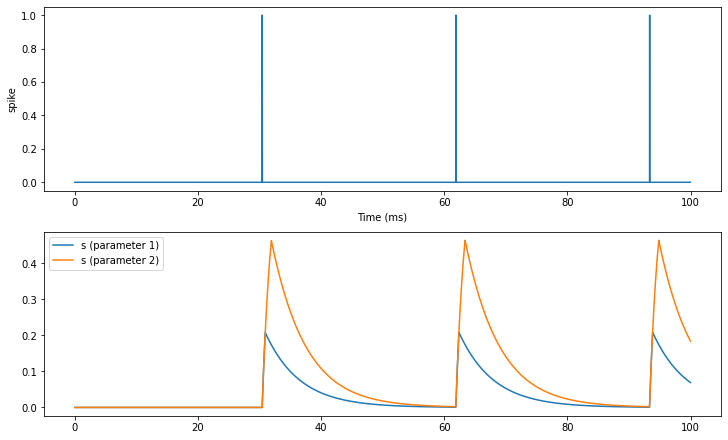

In [7]:
neu1 = LIF(1, monitors=['V', 'spike'])
neu2 = LIF(1, monitors=['V'])
syn1 = AMPA(pre=neu1, post=neu2, conn=bp.connect.All2All(), 
           alpha=0.98, beta=0.18, T=0.5, T_duration=0.5, monitors=['s'])
net1 = bp.Network(neu1, syn1, neu2)
net1.run(100., inputs=(neu1, 'input', 21.))

neu3 = LIF(1, monitors=['V', 'spike'])
neu4 = LIF(1, monitors=['V'])
syn2 = AMPA(pre=neu3, post=neu4, conn=bp.connect.All2All(), 
           alpha=0.98, beta=0.18, T=0.5, T_duration=1.5, monitors=['s'])
net2 = bp.Network(neu3, syn2, neu4)
net2.run(100., inputs=(neu3, 'input', 21.))

fig, gs = bp.visualize.get_figure(2, 1, 3, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(neu1.mon.ts, neu1.mon.spike, ylabel='spike')
fig.add_subplot(gs[1, 0])
plt.plot(syn1.mon.ts, syn1.mon.s[:, 0], label='s (parameter 1)')
plt.plot(syn2.mon.ts, syn2.mon.s[:, 0], label='s (parameter 2)')
plt.legend()

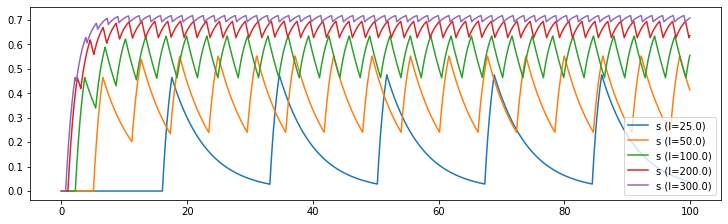

In [8]:
Iext = np.array([25., 50, 100, 200, 300])

neu1 = LIF(len(Iext), monitors=['V', 'spike'])
neu2 = LIF(len(Iext), monitors=['V'])
syn1 = AMPA(pre=neu1, post=neu2, conn=bp.connect.One2One(), 
           alpha=0.98, beta=0.18, T=0.5, T_duration=1.5, monitors=['s'])
net1 = bp.Network(neu1, syn1, neu2)
net1.run(100., inputs=(neu1, 'input', Iext))

fig, gs = bp.visualize.get_figure(1, 1, 3, 10)
for i in range(Iext.shape[0]):
    plt.plot(syn1.mon.ts, syn1.mon.s[:, i], label=f's (I={Iext[i]})')
plt.legend()

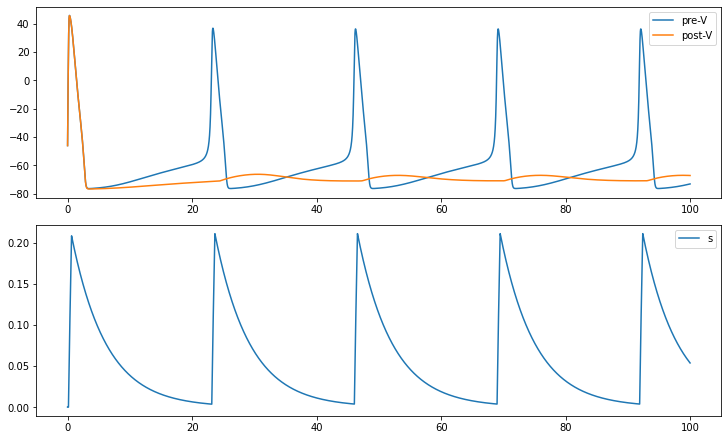

In [9]:
neu1 = HH(1, monitors=['V', 'spike'])
neu2 = HH(1, monitors=['V'])
syn1 = AMPA(pre=neu1, post=neu2, conn=bp.connect.All2All(), g_max=0.1, monitors=['s'])
net1 = bp.Network(neu1, syn1, neu2)
net1.run(100., inputs=(neu1, 'input', 3.5))

fig, gs = bp.visualize.get_figure(2, 1, 3, 10)
fig.add_subplot(gs[0, 0])
plt.plot(neu1.mon.ts, neu1.mon.V[:, 0], label='pre-V')
plt.plot(neu2.mon.ts, neu2.mon.V[:, 0], label='post-V')
plt.legend()
fig.add_subplot(gs[1, 0])
plt.plot(syn1.mon.ts, syn1.mon.s[:, 0], label='s')
plt.legend()

## GABAA synapse model

GABAA synapse has the same equation with the AMPA synapse, but with the difference of:

-  Reversal potential of synapse $E=-80.$ mV 
- Activating rate constant $\alpha=0.53$
- De-activating rate constant $\beta=0.18$
- Transmitter concentration $[T]=1\,\mu ho(\mu S)$ when synapse is triggered by a pre-synaptic spike, with the duration of 1. ms. 

In [12]:
# mimic AMPA model, please code the synapse model of BABAA

class GABAA(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, alpha=0.53, beta=0.18, g_max=0.5, 
                 E=-80., T=1., T_duration=1., delay=1., **kwargs):
      # parameters
      self.alpha, self.beta = alpha, beta
      self.T, self.T_duration = T, T_duration
      self.E, self.g_max = E, g_max
      self.delay = delay

      # connections
      self.conn = conn(pre.size, post.size)
      self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
      self.size = len(self.pre_ids)

      # variables
      self.s = bp.ops.zeros(self.size)
      self.t_last_pre_spike = -1e7 * bp.ops.ones(self.size)
      self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

      self.int_s = bp.odeint(f=self.derivative, method = 'exponential_euler')
      super(GABAA, self).__init__(pre=pre, post=post, **kwargs)
    
    @staticmethod
    def derivative(s, t, TT, alpha, beta):
        ds = alpha * TT * (1 - s) - beta * s
        return ds
    
    def update(self, _t):
      for i in range(self.size):
        pre_id, post_id = self.pre_ids[i], self.post_ids[i]
        
        # update
        if self.pre.spike[pre_id]: self.t_last_pre_spike[pre_id] = _t
        TT = ((_t - self.t_last_pre_spike[pre_id]) < self.T_duration) * self.T
        self.s[i] = self.int_s(self.s[i], _t, TT, self.alpha, self.beta)
        self.g.push(i, self.g_max * self.s[i])

        # output
        self.post.input[post_id] -= self.g.pull(i) * (self.post.V[post_id] - self.E)

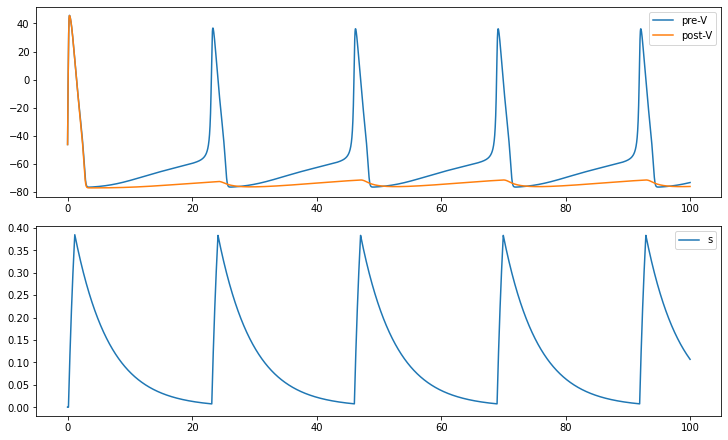

In [13]:
neu1 = HH(1, monitors=['V', 'spike'])
neu2 = HH(1, monitors=['V'])
syn1 = GABAA(pre=neu1, post=neu2, conn=bp.connect.All2All(), g_max=1, monitors=['s'])
net1 = bp.Network(neu1, syn1, neu2)
net1.run(100., inputs=(neu1, 'input', 3.5))

fig, gs = bp.visualize.get_figure(2, 1, 3, 10)
fig.add_subplot(gs[0, 0])
plt.plot(neu1.mon.ts, neu1.mon.V[:, 0], label='pre-V')
plt.plot(neu2.mon.ts, neu2.mon.V[:, 0], label='post-V')
plt.legend()
fig.add_subplot(gs[1, 0])
plt.plot(syn1.mon.ts, syn1.mon.s[:, 0], label='s')
plt.legend()